In [1]:
import csv, os
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, \
    precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression

from scipy.stats import ttest_ind

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

In [2]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
# Matches the feature names of the logistic regression to understandable titles
logistic_regression_col_names = {
    'cast_max': 'Highest actor score in RM',
    'cast_mean': 'Casting’s average score in RM',
    'cast_median': 'Cast’s median score in RM',
    'cast_nb_famous_actors': 'Number of famous actors in RM',
    'cast_prop_famous_actors': 'Ratio of famous actors in RM',
    'F_max': 'Most famous female actress score in RM',
    'F_mean': 'Average score of the female casting of the RM',
    'F_median': 'Median score of the female casting of the RM',
    'F_nb_famous_actors': 'Number of famous female actresses in RM',
    'F_prop_famous_actors': 'Ratio of famous female actresses in RM',
    'M_max': 'Most famous male actor in RM',
    'M_mean': 'Average score of the male casting of the RM',
    'M_median': 'Median score of the male casting of the RM',
    'M_nb_famous_actors': 'Number of famous male actors in RM',
    'M_prop_famous_actors': 'Ratio of famous male actors in RM',
    'previous_cast_max': 'Score of the most famous actor the actor has played within the past three years',
    'previous_cast_mean': 'Average score of all actors the actor has played within the past three years',
    'previous_cast_prop_famous_actors': 'Average ratio of famous actors among each movie the actor has played within the past three years',
    'previous_cast_nb_famous_actors': 'Total number of famous actors the actor has played with within the past three years',
    'm_release_year': 'Movie release year',
    'actor_age': 'Actor age',
    'actor_gender_cat': 'Female gender',
    'nb_movies_before_this_movie': 'Number of movies the actor has already starred in'
}

# 1. Load the preprocessed data

In [4]:
DATA_PATH = './preprocessed_data'
IMG_PATH = './images'
CHAR_PATH = os.path.join(DATA_PATH, 'characters_preprocessed.tsv')
SCORE_FUNCTION_PATH = os.path.join(DATA_PATH, 'score_function.tsv')
OUTPUT_LOGISTIC_IMAGES_PATH = os.path.join(IMG_PATH, 'regression')

## 1.1 Characters dataset

In [5]:
df_chars = pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date'] = pd.to_datetime(df_chars['m_release_date'], errors='coerce')
df_chars['actor_dob'] = pd.to_datetime(df_chars['actor_dob'], errors='coerce')
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year,min_year_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,NaN,NaN
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,2000.0,57.0


## 1.2 The score function

In [6]:
df_numbers = pd.read_csv(SCORE_FUNCTION_PATH, sep='\t')
df_numbers.set_index('actor_name', inplace=True)
df_numbers.head(2)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,99.0,346.5,181.5,123.75,94.050000,75.900000,441.642857,243.803571,174.125000,137.400000,...,892.587692,462.089744,317.717532,244.955719,200.891379,171.213548,149.784285,133.531250,1980,99.0
Clint Eastwood,348.0,174.0,460.0,729.00,1755.266667,1706.666667,1880.347619,1189.833333,1686.509524,1454.709524,...,2139.009068,1715.610398,1470.104342,3616.394846,2334.278040,1850.068876,1576.740235,1825.545952,1980,348.0


# 2. Dataset preparation

#### Add a new column: 
* `min_year_starring`: it corresponds to the starting year of career of an actor

In [7]:
map_min_year_starring = df_chars.groupby(['actor_name'])['m_release_year'].min()
df_chars['min_year_starring'] = df_chars['actor_name'].map(lambda x: map_min_year_starring[x])

#### Add two new columns:
* `is_revealed`: boolean which is true if the release year of the movie the actor is starring in correspond to the year the actor has appeared in the numbers' ranking for the first time
* `already_revealed`: boolean which is true if the release year of the movie the actor is starring in correspond to a greater year than your revelation year: the actor has already appeared in the numbers ranking before starring in this movie

In [8]:
df_chars['is_revealed'] = df_chars.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars['already_revealed'] = df_chars.apply(
    lambda row: row['min_year'] < row['m_release_date'].year and row['min_year'] != 0.0, axis=1).astype(int)

#### Add a new column:
* `popularity`: Categorical column which takes three possible values: **famous**, **revelation**, **unknown**. It corresponds to, at the release year of the movie, either: have been already revealed in the numbers at that time, being revealed at that time, or haven't been revealed at that time.

In [9]:
def get_popularity(row):
    """
    Compute the popularity of each actor at a period
    :param row: row of the df
    :return: the popularity, ie: famous (already revealed), revelation(being revealed) or unknown (not yet revealed)
    """
    if (row.is_revealed == 0) and (row.already_revealed == 0):
        return 'unknown'
    if (row.is_revealed == 0) and (row.already_revealed == 1):
        return 'famous'
    if (row.is_revealed == 1) and (row.already_revealed == 0):
        return 'revelation'
    if (row.is_revealed == 1) and (row.already_revealed == 1):
        raise ValueError('The actor {} has a value 1 for is_revealed and 1 for already_revealed'.format(row.actor_name))

In [10]:
df_chars['popularity'] = df_chars.apply(lambda row: get_popularity(row), axis=1)

# 3. Regression analysis: how co-acting impacts being revealed
## 3.1 Features of actor score

In [11]:
df_regression = df_chars.copy()

#### Column conversion
* add a column `actor_gender_cat`: it represents the actor gender as a binary input

In [12]:
df_regression['actor_gender_cat'] = (df_regression['actor_gender'] == 'F').astype(int)

#### Drop columns 
* Two columns won't be used for the analysis: `actor_height` and `actor_ethnicity`

In [13]:
df_regression.drop(['actor_height', 'actor_ethnicity', 'm_release_date'], axis=1, inplace=True)

#### Number of actors per movie
* add a new column: `nb_actors`: Number of actors per movie

In [14]:
#compute number of actors per movie
map_nb_actors_per_movie = df_regression.groupby(['wikipedia_m_ID'])['actor_name'].count()
df_regression['nb_actors'] = df_regression['wikipedia_m_ID'].map(lambda x: map_nb_actors_per_movie[x])

#### Number of movies of each actor before releasing movie
* add a new column `nb_movies_before_releasing_movie`: it corresponds to the number of movies an actor has starred in before playing in the movie row

In [15]:
map_nb_movies_per_year = df_regression.groupby(['actor_name', 'm_release_year'])['wikipedia_m_ID'].count().reset_index()

In [16]:
year = range(1980, 2013)
list_nb_movies_at_year = dict()
for y in year:
    filter_conditions = (
        (map_nb_movies_per_year['m_release_year'] < y)
    )
    list_nb_movies = map_nb_movies_per_year.loc[filter_conditions]
    list_nb_movies = list_nb_movies.groupby('actor_name')['wikipedia_m_ID'].sum()
    list_nb_movies_at_year.update({y: list_nb_movies})

In [17]:
def get_nb_movies_before_year(row):
    """
    Retrieve the number of movies an actor has starred in before the movie release year of a specific movie
    :param row: row of the df characters
    :return: The number of movies the actor has performed
    """
    release_year = row['m_release_year']
    actor_name = row['actor_name']
    try:
        df_tmp = list_nb_movies_at_year[release_year]
        nb_movies = df_tmp[actor_name]
        return nb_movies
    except:
        return 0

In [18]:
df_regression['nb_movies_before_this_movie'] = df_regression.apply(lambda row: get_nb_movies_before_year(row), axis=1)

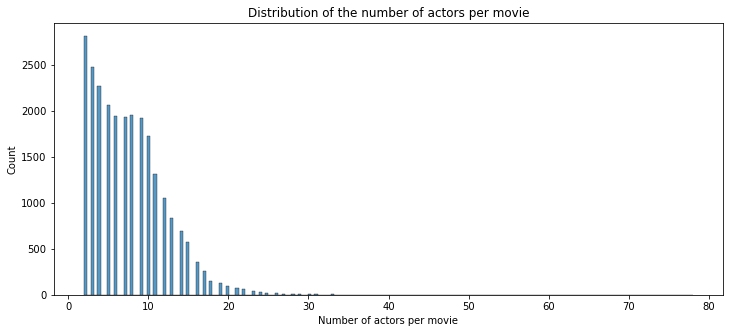

In average, there are 7.61 actors per movie in our dataset.
It corresponds to 24884 different movies.


In [19]:
# Number of actors per movie
plt.figure(figsize=(12, 5))
sns.histplot(data=df_regression.drop_duplicates('wikipedia_m_ID'), x='nb_actors')
plt.title("Distribution of the number of actors per movie")
plt.ylabel("Count")
plt.xlabel("Number of actors per movie")
plt.show()
avg_nb_actors_per_movie = df_regression.drop_duplicates('wikipedia_m_ID')['nb_actors'].mean()
nb_unique_movies_with_actors = df_regression['wikipedia_m_ID'].nunique()
print("In average, there are {:.2f} actors per movie in our dataset.".format(avg_nb_actors_per_movie))
print("It corresponds to {} different movies.".format(nb_unique_movies_with_actors))

#### Number of movies per decade
* Add four columns that compute the number of movies an actor has performed during each decade

In [20]:
nb_decades_lower = range(1980, 2030, 10)
nb_decades_upper = range(1990, 2030, 10)
list_decades = dict()
for dec_lower, dec_upper in zip(nb_decades_lower, nb_decades_upper):
    filter_conditions = (
            (map_nb_movies_per_year['m_release_year'] >= dec_lower) &
            (map_nb_movies_per_year['m_release_year'] < dec_upper)
    )
    list_dec = map_nb_movies_per_year.loc[filter_conditions]
    list_dec = list_dec.groupby('actor_name')['wikipedia_m_ID'].count().reset_index()
    list_dec['wikipedia_m_ID'] = list_dec['wikipedia_m_ID'].astype(int)
    list_dec.rename({'wikipedia_m_ID': 'nb_movies_dec_{}_{}'.format(dec_lower, dec_upper)}, axis=1, inplace=True)
    list_decades.update({range(dec_lower, dec_upper): list_dec})

In [21]:
for key, dec in list_decades.items():
    df_regression = df_regression.merge(dec, on='actor_name', how='left')
    df_regression['nb_movies_dec_{}_{}'.format(key.start, key.stop)].fillna(0, inplace=True)

In [22]:
df_regression.head(2)

,wikipedia_m_ID,character_name,actor_dob,actor_gender,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year,...,is_revealed,already_revealed,popularity,actor_gender_cat,nb_actors,nb_movies_before_this_movie,nb_movies_dec_1980_1990,nb_movies_dec_1990_2000,nb_movies_dec_2000_2010,nb_movies_dec_2010_2020
0,975900,Akooshay,1958-08-26,F,Wanda De Jesus,42.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,NaN,...,0,0,unknown,1,13,3,0.0,2.0,4.0,0.0
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,Natasha Henstridge,27.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,2000.0,...,0,1,famous,1,13,8,0.0,3.0,6.0,0.0


#### Retrieve the scores per actor at movie time
* add a new column `actor_score`: it corresponds to the score of the actor at the year before starring the movie

In [23]:
def retrieve_actor_score(row):
    """
    Retrieve the actor score the year before the movie release
    :param row: row of the df characters
    :return: The actor score the actor has the year before the release year
    """
    score_year_to_retrieve = row['m_release_year'] - 1
    actor_name = row['actor_name']
    try:
        return df_numbers['{}'.format(score_year_to_retrieve)][actor_name]
    except:
        return 0

In [24]:
df_regression['actor_score'] = df_regression.apply(lambda row: retrieve_actor_score(row), axis=1)

#### Keep only movies strictly after 1980 (minimal year for which we have an actor score)

In [25]:
# Keep only movies after 1980
df_regression = df_regression[df_regression['m_release_year'] > 1980].copy()

#### Quick analysis just for fun

In [26]:
nb_unique_movies = df_regression['wikipedia_m_ID'].nunique()
print("There are {} unique movies released after 1980 and with at least two actors in the dataset.".format(
    nb_unique_movies))

There are 13712 unique movies released after 1980 and with at least two actors in the dataset.


In [27]:
nb_actors = df_regression['actor_name'].nunique()
nb_actors_who_started_carreer_after_1980 = df_regression.loc[(df_regression['nb_movies_before_this_movie'] == 0)][
    'actor_name'].nunique()
print("There are {} actors in this dataset.".format(nb_actors))
print("Among them, there are {} actors who had started their carreer before 1980.".format(
    nb_actors - nb_actors_who_started_carreer_after_1980))

There are 24701 actors in this dataset.
Among them, there are 3732 actors who had started their carreer before 1980.


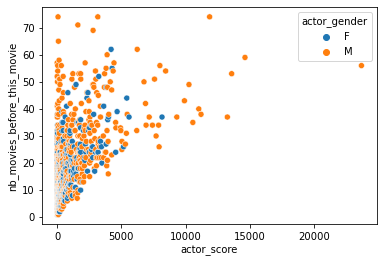

In [28]:
sns.scatterplot(
    data=df_regression.loc[(df_regression['actor_score'] > 0)].sort_values('actor_score').drop_duplicates('actor_name',
                                                                                                          keep='last'),
    y='nb_movies_before_this_movie', x='actor_score', hue="actor_gender");

In [29]:
women_nb_movies_highest_score = \
    df_regression.loc[(df_regression['actor_score'] > 0) & (df_regression['actor_gender'] == 'F')].sort_values(
        'actor_score').drop_duplicates('actor_name', keep='last')['nb_movies_before_this_movie']
men_nb_movies_highest_score = \
    df_regression.loc[(df_regression['actor_score'] > 0) & (df_regression['actor_gender'] == 'M')].sort_values(
        'actor_score').drop_duplicates('actor_name', keep='last')['nb_movies_before_this_movie']

In [30]:
women_mean_nb_movies_highest_score = women_nb_movies_highest_score.mean()
men_mean_nb_movies_highest_score = men_nb_movies_highest_score.mean()
print("At the peak of their carreer, women had before performed {:.2f} movies in average.".format(
    women_mean_nb_movies_highest_score))
print("At the peak of their carreer, men had before performed {:.2f} movies in average.".format(
    men_mean_nb_movies_highest_score))
ttest_ind(women_nb_movies_highest_score, men_nb_movies_highest_score)

At the peak of their carreer, women had before performed 12.32 movies in average.
At the peak of their carreer, men had before performed 16.21 movies in average.


Ttest_indResult(statistic=-5.362465244255523, pvalue=9.619260122200605e-08)

In [31]:
women_highest_score = \
    df_regression.loc[(df_regression['actor_score'] > 0) & (df_regression['actor_gender'] == 'F')].sort_values(
        'actor_score').drop_duplicates('actor_name', keep='last')['actor_score']
men_highest_score = \
    df_regression.loc[(df_regression['actor_score'] > 0) & (df_regression['actor_gender'] == 'M')].sort_values(
        'actor_score').drop_duplicates('actor_name', keep='last')['actor_score']

In [32]:
women_mean_highest_score = women_highest_score.mean()
men_mean_highest_score = men_highest_score.mean()
print("At the peak of their career, women have in average reached a score of {:.2f}.".format(women_mean_highest_score))
print("At the peak of their career, men have in average reached a score of {:.2f}.".format(men_mean_highest_score))
ttest_ind(women_highest_score, men_highest_score)

At the peak of their career, women have in average reached a score of 525.89.
At the peak of their career, men have in average reached a score of 890.59.


Ttest_indResult(statistic=-4.022467941449092, pvalue=6.0723689662790975e-05)

## 3.2 Compute movie features
#### Merge actors information for each movie

In [33]:
columns = ['wikipedia_m_ID', 'actor_name', 'actor_gender', 'actor_score']
df_temp = df_regression.copy()
df_temp['actor_score'] = df_temp['actor_score'].astype(str)
df_temp['actor_gender'] = df_temp['actor_gender'].astype(str)
df_movies_features = df_temp[columns].groupby('wikipedia_m_ID').agg(
    {'actor_name': '$l$'.join, 'actor_gender': '$l$'.join, 'actor_score': '$l$'.join})

In [34]:
df_movies_features.head(2)

,actor_name,actor_gender,actor_score
wikipedia_m_ID,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M,0.0$l$250.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0....


#### Compute the features of each movie

In [35]:
def get_function_of_list_values(row, function, gender_att=None):
    """
    Retrieve the number of movies an actor has starred in before the movie release year of a specific movie

    :param row: row of the df movies
    :param function: function to apply to the list of scores of each actor
    :param gender_att: either 'F', 'M' or None. The function will be either performed on the entire list of scores or
                       just a specific gender
    :return: The function applied to the list of scores
    """

    list_temp = row['actor_score'].split('$l$')
    gender_split = row['actor_gender'].split('$l$')
    list_temp = [float(x) for x in list_temp]
    if gender_att:
        list_split = []
        for x, gender in zip(list_temp, gender_split):
            if gender == gender_att:
                list_split.append(x)
    else:
        list_split = list_temp
    if len(list_split) == 0:
        return np.nan
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        if gender_att:
            try:
                return (np.count_nonzero(list_split)) / float(len(list_temp))
            except:
                return 0
        else:
            return (np.count_nonzero(list_split)) / float(len(list_split))

In [36]:
# Operations that will be applied for each casting
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
for f in list_function_score:
    df_movies_features['cast_' + f] = df_movies_features.apply(
        lambda row: get_function_of_list_values(row, f), axis=1)

In [37]:
gender_list = ['M', 'F']
for gender in gender_list:
    for f in list_function_score:
        df_movies_features[gender + '_' + f] = df_movies_features.apply(
            lambda row: get_function_of_list_values(row, f, gender_att=gender), axis=1)
        
df_movies_features.head(2)

,actor_name,actor_gender,actor_score,cast_max,cast_min,cast_mean,cast_median,cast_nb_famous_actors,cast_prop_famous_actors,M_max,...,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,F_max,F_min,F_mean,F_median,F_nb_famous_actors,F_prop_famous_actors
wikipedia_m_ID,,,,,,,,,,,,,,,,,,,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...,0.0,0.0,0.000000,0.0,0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M,0.0$l$250.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0....,250.0,0.0,19.230769,0.0,1,0.076923,250.0,...,25.0,0.0,1.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0


## 3.3 Compute actor story
#### Merge each actor movie with the corresponding movie features
When having played several movies in the same year, the movie features are grouped using the average

In [38]:
list_columns = ['cast_' + x for x in list_function_score] + ['F_' + x for x in list_function_score] + ['M_' + x for x in
                                                                                                       list_function_score]

In [39]:
df_regression_merged = df_regression.merge(df_movies_features[list_columns], left_on='wikipedia_m_ID', right_index=True,
                                           how='left').copy()

df_regression_merged = df_regression_merged.groupby(['actor_name', 'm_release_year']).mean().reset_index()
df_regression_merged.head(3)

,actor_name,m_release_year,wikipedia_m_ID,actor_age,min_year,min_year_score,min_year_starring,is_revealed,already_revealed,actor_gender_cat,...,F_mean,F_median,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors
0,Daniel Newman,1998,20116200.0,22.0,NaN,NaN,1998.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,136.666667,0.0,19.523810,0.0,1.0,0.111111
1,2 Tuff Tony,2010,11901968.0,35.0,NaN,NaN,2010.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,189.025641,0.0,14.452769,0.0,2.0,0.133333
2,40 Glocc,2009,21029252.0,29.0,NaN,NaN,2009.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


#### Mapping past of actor

The previous features of movie the actor has starred in in the past three years are merged to each actor movie.

In [40]:
aggregation = {"cast_max": "max", "cast_mean": "mean", "cast_prop_famous_actors": "mean",
               "cast_prop_famous_actors": "max", "cast_nb_famous_actors": "max"}
map_past_of_actor = df_regression_merged.groupby(['actor_name', 'm_release_year']).agg(aggregation).reset_index()

In [41]:
year = range(1982, 2013)
list_past_actors_per_year = pd.DataFrame()
for y in year:
    filter_conditions = (
            (map_past_of_actor['m_release_year'] >= y - 3) &
            (map_past_of_actor['m_release_year'] <= y)
    )
    list_past_actors = map_past_of_actor.loc[filter_conditions].copy()
    list_past_actors = list_past_actors.groupby('actor_name').agg(aggregation)
    previous_col = list_past_actors.columns
    list_past_actors.columns = ['previous_' + c for c in previous_col]
    list_past_actors['m_release_year'] = list_past_actors.apply(lambda row: y, axis=1)
    list_past_actors_per_year = pd.concat([list_past_actors_per_year, list_past_actors])

list_past_actors_per_year.reset_index(inplace=True)

In [42]:
df_regression_merged = df_regression_merged.merge(list_past_actors_per_year, on=['actor_name', 'm_release_year'], how='left')
df_regression_merged.head(2)

,actor_name,m_release_year,wikipedia_m_ID,actor_age,min_year,min_year_score,min_year_starring,is_revealed,already_revealed,actor_gender_cat,...,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,previous_cast_max,previous_cast_mean,previous_cast_prop_famous_actors,previous_cast_nb_famous_actors
0,Daniel Newman,1998,20116200.0,22.0,NaN,NaN,1998.0,0.0,0.0,0.0,...,136.666667,0.0,19.523810,0.0,1.0,0.111111,136.666667,15.185185,0.111111,1.0
1,2 Tuff Tony,2010,11901968.0,35.0,NaN,NaN,2010.0,0.0,0.0,0.0,...,189.025641,0.0,14.452769,0.0,2.0,0.133333,189.025641,13.489251,0.133333,2.0


#### Filter out actors when movie released date was after his·her revelation

As the focus is on the conditions for an actor to be releaved, the rows corresponding to actors who are already revealed are dropped.

In [43]:
filter_conditions = (
    (df_regression_merged['already_revealed'] == 0)

)
df_final = df_regression_merged.loc[filter_conditions].copy()
df_final.head(2)

,actor_name,m_release_year,wikipedia_m_ID,actor_age,min_year,min_year_score,min_year_starring,is_revealed,already_revealed,actor_gender_cat,...,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,previous_cast_max,previous_cast_mean,previous_cast_prop_famous_actors,previous_cast_nb_famous_actors
0,Daniel Newman,1998,20116200.0,22.0,NaN,NaN,1998.0,0.0,0.0,0.0,...,136.666667,0.0,19.523810,0.0,1.0,0.111111,136.666667,15.185185,0.111111,1.0
1,2 Tuff Tony,2010,11901968.0,35.0,NaN,NaN,2010.0,0.0,0.0,0.0,...,189.025641,0.0,14.452769,0.0,2.0,0.133333,189.025641,13.489251,0.133333,2.0


#### Quick analysis of the number of movies an actor has starred in before being revealed

<AxesSubplot:xlabel='nb_movies_before_this_movie', ylabel='Count'>

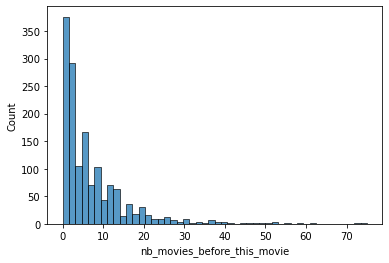

In [44]:
sns.histplot(data=df_final[df_final['is_revealed'] == 1], x='nb_movies_before_this_movie')

<AxesSubplot:>

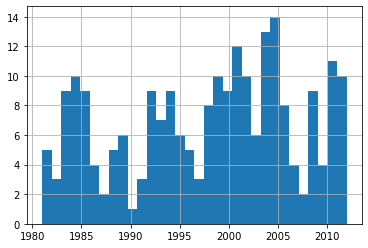

In [45]:
df_final.loc[(df_final['is_revealed'] == 1) & (df_final['nb_movies_before_this_movie'] == 0)]['m_release_year'].hist(
    bins=32)

## 3.4 Actor revelation quick view
Each row represents a configuration, i.e. the past of an actor as well as the features of the movie he·she was revealed with.

In [46]:
nb_configurations = df_final['actor_name'].count()
nb_actors = df_final['actor_name'].nunique()
print("{} configurations will be compared, mapping configurations of {} actors.".format(nb_configurations, nb_actors))
# Those configurations represent the situation of an actor and its output (is revealed or not).

76643 configurations will be compared, mapping configurations of 24628 actors.


In [47]:
nb_configurations_revelation = df_final['is_revealed'].sum()
print(
    "Among those configurations, {} of them lead to the revelation of the actor, which represents {:.2f}% of the configurations.".format(
        nb_configurations_revelation, nb_configurations_revelation * 100 / nb_configurations))

Among those configurations, 1492.0 of them lead to the revelation of the actor, which represents 1.95% of the configurations.


## 3.5 Average per past feature and revelation movie feature

In [48]:
df_final.groupby('is_revealed').mean()

,m_release_year,wikipedia_m_ID,actor_age,min_year,min_year_score,min_year_starring,already_revealed,actor_gender_cat,nb_actors,nb_movies_before_this_movie,...,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,previous_cast_max,previous_cast_mean,previous_cast_prop_famous_actors,previous_cast_nb_famous_actors
is_revealed,,,,,,,,,,,,,,,,,,,,,
0.0,1999.204522,1.025827e+07,38.713449,1789.577317,46.775554,1989.36927,0.0,0.341952,11.023397,5.616293,...,605.060644,-6.998647,80.423525,3.290879,1.133796,0.090112,1085.356094,66.196873,0.175462,2.233364
1.0,1998.049598,7.224766e+06,31.714711,1998.049598,57.553619,1989.83311,0.0,0.380027,13.375597,7.127346,...,1071.751888,-2.101120,140.960263,7.427677,1.713647,0.121838,1789.945184,98.703881,0.226658,3.184697


<AxesSubplot:xlabel='is_revealed', ylabel='cast_prop_famous_actors'>

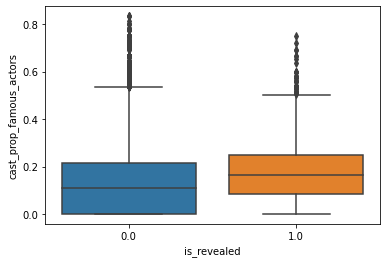

In [49]:
sns.boxplot(data=df_final, x='is_revealed', y='cast_prop_famous_actors')

<AxesSubplot:xlabel='is_revealed', ylabel='previous_cast_prop_famous_actors'>

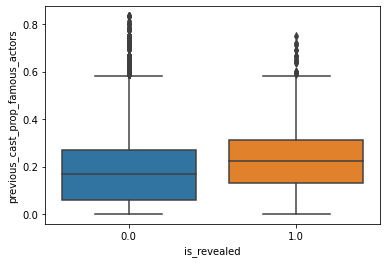

In [50]:
sns.boxplot(data=df_final, x='is_revealed', y='previous_cast_prop_famous_actors')

<AxesSubplot:xlabel='is_revealed', ylabel='cast_max'>

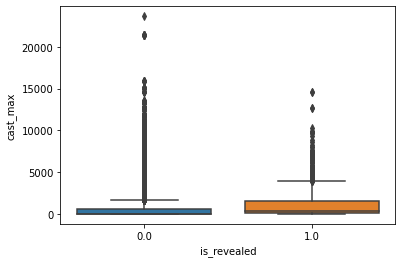

In [51]:
sns.boxplot(data=df_final, x='is_revealed', y='cast_max')

<AxesSubplot:xlabel='is_revealed', ylabel='previous_cast_max'>

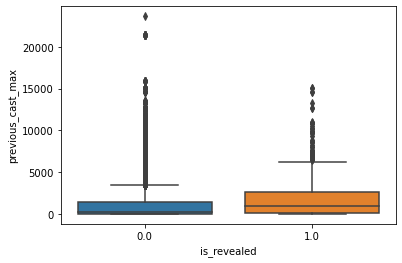

In [52]:
sns.boxplot(data=df_final, x='is_revealed', y='previous_cast_max')

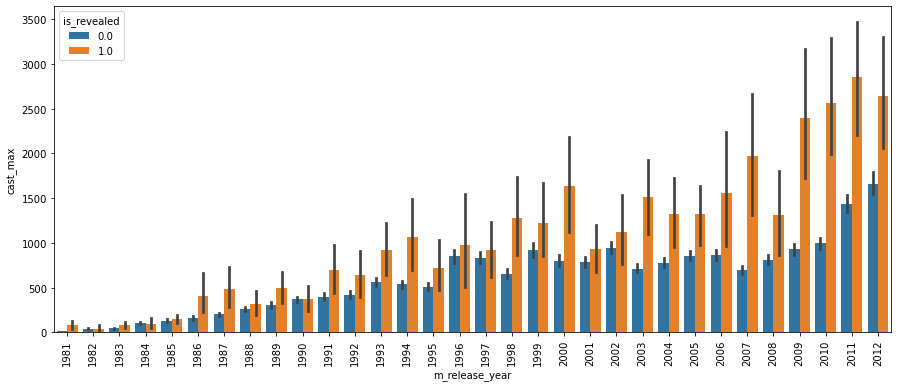

In [53]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_final, x='m_release_year', y='cast_max', hue='is_revealed')
plt.xticks(rotation=90);

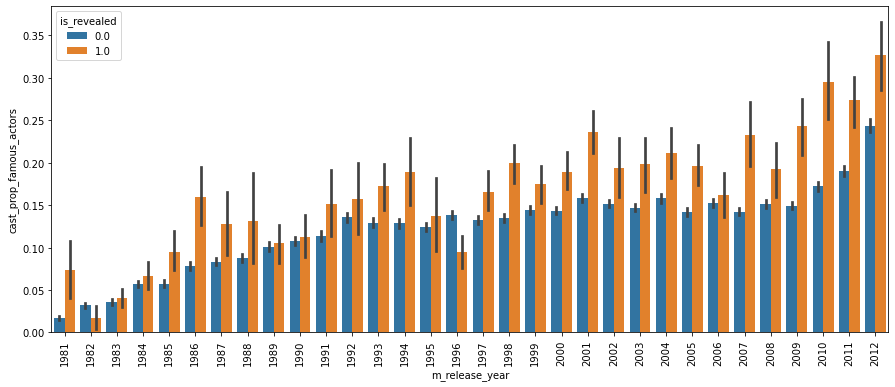

In [54]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_final, x='m_release_year', y='cast_prop_famous_actors', hue='is_revealed')
plt.xticks(rotation=90);

In [55]:
revealed_ = df_final[df_final['is_revealed'] == 1]
not_revealed_ = df_final[df_final['is_revealed'] == 0]
ttest_ind(revealed_['cast_prop_famous_actors'], not_revealed_['cast_prop_famous_actors'])

Ttest_indResult(statistic=13.019113457805622, pvalue=1.0473135136300964e-38)

In [56]:
ttest_ind(revealed_['cast_max'], not_revealed_['cast_max'])

Ttest_indResult(statistic=12.75558767004207, pvalue=3.1664583881185393e-37)

In [57]:
ttest_ind(revealed_['cast_nb_famous_actors'], not_revealed_['cast_nb_famous_actors'])

Ttest_indResult(statistic=16.034350937105494, pvalue=9.135439546887984e-58)

## 3.6 Actor revelation prediction

In [58]:
features_regression = ['cast_max', 'cast_mean', 'cast_median', 'cast_nb_famous_actors','cast_prop_famous_actors', 
                       'F_max', 'F_mean', 'F_median', 'F_nb_famous_actors', 'F_prop_famous_actors', 
                       'M_max', 'M_mean', 'M_median', 'M_nb_famous_actors', 'M_prop_famous_actors', 
                       'previous_cast_max', 'previous_cast_mean', 'previous_cast_prop_famous_actors',
                       'previous_cast_nb_famous_actors', 
                       'm_release_year', 'actor_age', 'actor_gender_cat', 'nb_movies_before_this_movie',
                       'is_revealed']

#### Select just one random sample for a quick analysis

In [59]:
nb_rows = df_final['is_revealed'].count()
nb_is_revealed = df_final['is_revealed'].sum()
weights = df_final['is_revealed'].apply(
    lambda x: 1 - nb_is_revealed / nb_rows if x else nb_is_revealed / nb_rows).to_list()
df_sampled = df_final.sample(n=4000, replace=True, weights=weights, random_state=1)

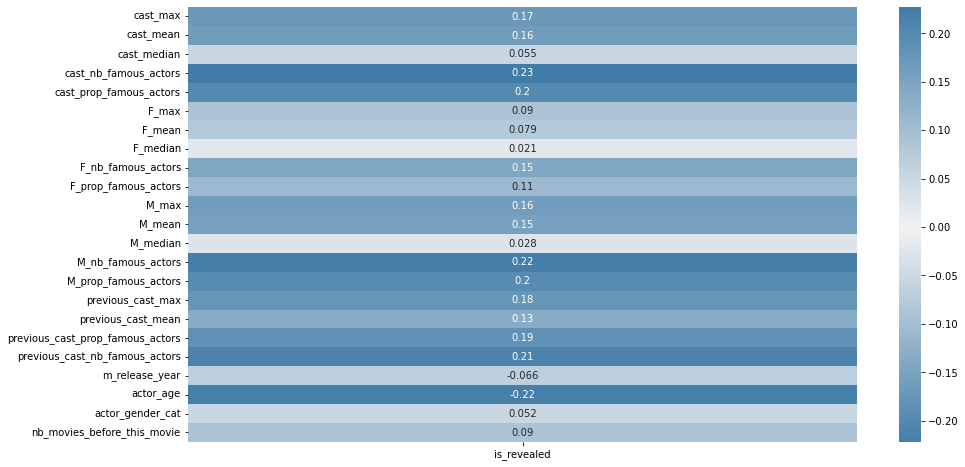

In [60]:
columns = features_regression
dataset = df_sampled[columns].fillna(0)

# Heatmap of the correlation between the attributes and the output 'is_revealed'
corr = dataset.corr()
corr.drop(corr.tail(1).index, inplace=True)

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240, 240, as_cmap=True)
sns.heatmap(data=corr[['is_revealed']], cmap=cmap, center=0, annot=True)
plt.show()

## 3.7 Prediction
Under-sampling will be performed as the dataset is substantially unbalanced. Bootstrapping with replacement will be performed in order to obtain a representative model.

In [61]:
def select_sample(data, target_column, seed, nb_samples):
    """
    Randomly selects a sample of size nb samples with replacement with each weight corresponding to each class weight

    :param data: df train set with only unknown or just revealed in the year actors
    :param target_column: name of the column to predict
    :param seed: random seed used to sample
    :param nb_samples: nb samples to retrieve when sampling
    :return: The sample from the dataset
    """

    rdness = datetime.now().time().microsecond
    nb_rows = data[target_column].count()
    nb_target_true = data[target_column].sum()
    weights = data[target_column].apply(lambda x: 1 - nb_target_true / nb_rows if x else nb_target_true/nb_rows).to_list()
    return data.sample(n=nb_samples, replace=True, weights=weights, random_state=seed*rdness)

In [62]:
def train_model(training_set, target_column, nb_samples, scaler, seed):
    """
    Train a logistic regression model on a sample of the training set

    :param training_set: df train set with only unknown or just revealed in the year actors
    :param target_column: name of the column to predict
    :param nb_samples: nb samples to retrieve when sampling
    :param scaler: scaler to scale the data
    :param seed: random seed used to sample
    :return: The classifier trained
    """

    subset = select_sample(training_set, target_column, seed, nb_samples)
    
    X_train = subset.drop(target_column, axis=1)
    y_train = subset[target_column]
    X_train = scaler.transform(X_train)

    clf = LogisticRegression(max_iter=10000, C=2, class_weight='balanced')
    clf.fit(X_train, y_train)
    return clf

In [63]:
def test_model(clf_, testing_set, target_column, nb_samples, scaler, seed):
    """
    Test the logistic regression model on a sample with replacement of the test set

    :param clf_: logistic regression classifier
    :param testing_set: df test set with only unknown or just revealed in the year actors
    :param target_column: name of the column to predict
    :param nb_samples: nb samples to retrieve when sampling
    :param scaler: scaler to scale the data
    :param seed: random seed used to sample
    :return: The true values of the sampled test set, the binary predictions and probability predictions
    """

    subset = select_sample(testing_set, target_column, seed, nb_samples)
    X_test = subset.drop(target_column, axis=1)
    X_test = scaler.transform(X_test)
    
    y_test = subset[target_column]
    y_pred = cross_val_predict(clf_, X_test, y_test, cv=10, method="predict")
    y_pred_proba = cross_val_predict(clf_, X_test, y_test, cv=10, method="predict_proba")
    return y_test, y_pred, y_pred_proba

In [64]:
def compute_regressor(data, feature_columns, target_column, nb_trials=100, nb_features=None, nb_samples_per_training=1000):
    """
    Compute a logistic regressor by sampling with replacement the training set and averages the weights of each model returned

    :param data: df to apply the regression on
    :param feature_columns: names of the feature columns of the prediction
    :param target_column: name of the column to predict
    :param nb_trials: number of models to train independently
    :param nb_features: number of features of the model
    :param nb_samples_per_training: number of samples to sample in the training set
    :returns: 
            - A dictionary of the regressor features: classifier, classification report, confusion matrix,
            precision/recall, false positive rate, true positive rate, precision-recall score, roc-score
            - tuple (scaler_mean, scaler_scale): the normalization applied to the features
    """

    output_dict = dict()

    # Load the dataset
    dataset = data[feature_columns].fillna(0)
    X = dataset.drop(target_column, axis=1)
    y = dataset[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

    # Standardize data according to the training features
    scaler = StandardScaler()
    scaler.fit(X_train)

    models = np.zeros((nb_trials, nb_features))
    for i in range(nb_trials):
        # Train independent models by sampling in the dataset
        model = train_model(pd.concat([X_train, y_train], axis=1), target_column, nb_samples=nb_samples_per_training, scaler=scaler, seed=i)
        models[i] = model.coef_[0]
    
    # Final classifier which weights will be the average of all the trained models
    clf = LogisticRegression(max_iter=10000, C=2, class_weight='balanced')
    clf.fit(X_train, y_train)
    clf.coef_[0] = models.mean(axis=0)
    
    output_dict.update({'clf': clf})
    
    # Predict the binary output with a cross validation
    y_true, y_pred, y_pred_proba = test_model(clf, pd.concat([X_test, y_test], axis=1),target_column, nb_samples_per_training, scaler, i)
    # Compute the False Positive Rate and True Positive Rate
    
    output_dict.update({'classification report': classification_report(y_true, y_pred)})
    
    # Creation of confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['0', '1'], index=['0', '1'])
    output_dict.update({'cm': conf_matrix})
    
    # Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba[:, 1])

    # Compute the false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])

    # Compute the area under the P-R curve and ROC curve
    pr_score = auc(recall, precision)
    roc_score = auc(fpr, tpr)
    
    output_dict.update({'precision': precision})
    output_dict.update({'recall': recall})
    output_dict.update({'fpr': fpr})
    output_dict.update({'tpr': tpr})
    output_dict.update({'pr_score': pr_score})
    output_dict.update({'roc_score': roc_score})
    
    return output_dict, (scaler.mean_, scaler.scale_)

In [65]:
def plot_logistic_regression_results(output_dict, output_filename, title=None):
    """
    Plot: classification report, confusion matrix, precision-recall curve and ROC curve

    :param output_dict: dictionary of the classifier with all its features
    :param output_filename: filename of the file to save the confusion matrix
    :param title: name of the regression being performed: 'is revealed' or 'still ranked'
    :return:
    """

    print("Classification report for {}:".format(title))
    print(output_dict['classification report'])

    # Plot confusion matrix
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    sns.heatmap(output_dict['cm'], annot=True, fmt='d', cmap='Reds')
    plt.title("Confusion matrix of the logistic regression for {}".format(title))
    plt.xlabel("Predicted value")
    plt.ylabel("True value")
    plt.show()
    
    image_format = 'svg'
    fig.savefig(output_filename, format=image_format, dpi=1200)
    
    # Plot P-R curve and ROC curve
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    ax = axs[0]
    ax.plot(output_dict['recall'], output_dict['precision'], label='logistic')
    ax.plot([1, 0], [0, 1], 'r--', label='no skill')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(output_dict['pr_score']))
    ax.legend(loc='lower left')

    ax = axs[1]
    ax.plot(output_dict['fpr'], output_dict['tpr'], label='logistic')
    ax.plot([0, 1], [0, 1], 'r--', label='no skill')
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.set_title("ROC Curve - Area = {:.3f}".format(output_dict['roc_score']))
    ax.legend(loc='lower right')

    fig.suptitle('Logistic regression for {}'.format(title))
    fig.tight_layout()
    plt.show()
    return

In [66]:
def compute_logistic_regression_weights(output_dict, feature_columns, output_filename):
    """
    Compute the logistic regression weight of each feature of the classifier

    :param output_dict: dictionary of the classifier with all its features
    :param feature_columns: name of the features of each classifier feature
    :param output_filename: filename of the file to save the barh plot of the feature contribution weight
    :return:
    """

    # Weight of each column in logistic regression
    tmp = []
    for name, value in zip(feature_columns, output_dict['clf'].coef_[0]):
        tmp.append({"name": logistic_regression_col_names[name], "value": value})

    features_coef = pd.DataFrame(tmp).sort_values("value")

    fig, axs = plt.subplots(figsize=(5, 7))
    plt.barh(features_coef.name, features_coef.value, alpha=0.6)
    fig.suptitle('Logistic regression analysis of the impact of coacting on being revealed \n RM: revelation movie')
    plt.show()
    plt.tight_layout()

    image_format = 'svg'
    image_name = output_filename

    fig.savefig(image_name, format=image_format, dpi=1200)
    return

In [67]:
def retrieve_regression_weights(output_dict, feature_columns, scaler, output_filename):
    """
    Retrieve the regression weights and normalization. Will be used to predict a new value entered by the user in 
    the data story

    :param output_dict: dictionary of the classifier with all its features
    :param feature_columns: name of the features of each classifier feature
    :param scaler: scaler normalization to apply to the data
    :param output_filename: filename of the file to save the csv of each feature contribution
    :return:
    """

    scaler_mean = scaler[0]
    scaler_std = scaler[1]
    regression_columns_weight = dict()
    regression_columns_mean = dict()
    for name, value , std in zip(feature_columns, output_dict['clf'].coef_[0], scaler_std):
        regression_columns_weight.update({name: value/std})
    for name, mean in zip(feature_columns, scaler_mean):
        regression_columns_mean.update({name: mean})
    
    with open(output_filename, 'w') as f:
        writer = csv.writer(f)
        for key, val in regression_columns_weight.items():
            row = [key, val]
            writer.writerow(row)
    return regression_columns_weight, regression_columns_mean

Classification report for Revelation actors:
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.69      1032
         1.0       0.66      0.68      0.67       968

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



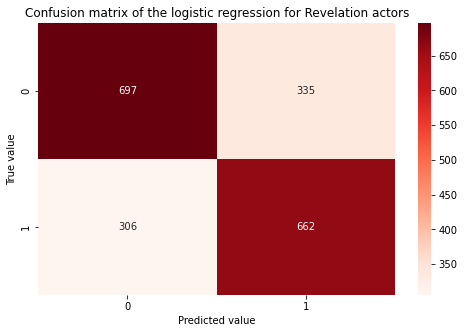

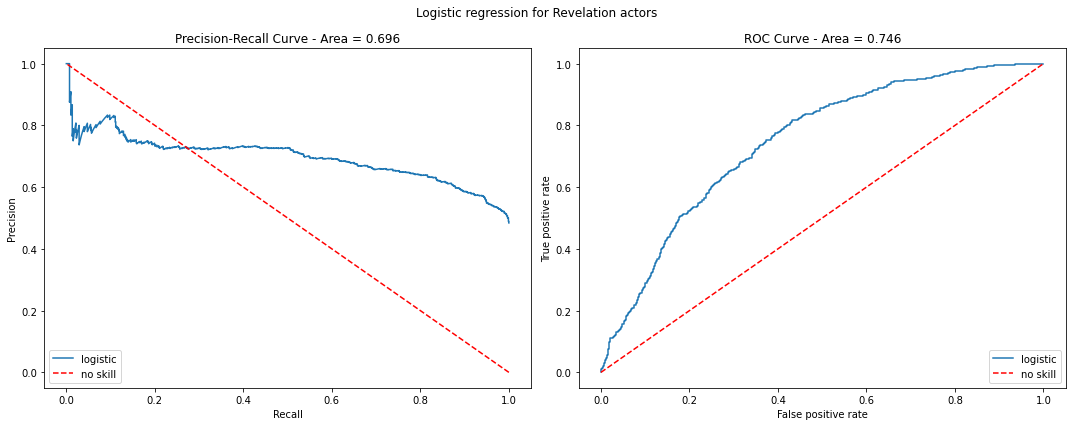

In [68]:
nb_trials = 100
nb_features = dataset.shape[1]-1
nb_samples_per_training = 2000
PATH_REGRESSION_REVELATION_CMATRIX = os.path.join(OUTPUT_LOGISTIC_IMAGES_PATH, 'regression_revelation_cm.svg')
regression_revelation_results, scaler = compute_regressor(df_final, feature_columns=columns, target_column='is_revealed', nb_trials=nb_trials, nb_features=nb_features, nb_samples_per_training=nb_samples_per_training)
plot_logistic_regression_results(regression_revelation_results, PATH_REGRESSION_REVELATION_CMATRIX, title='Revelation actors')

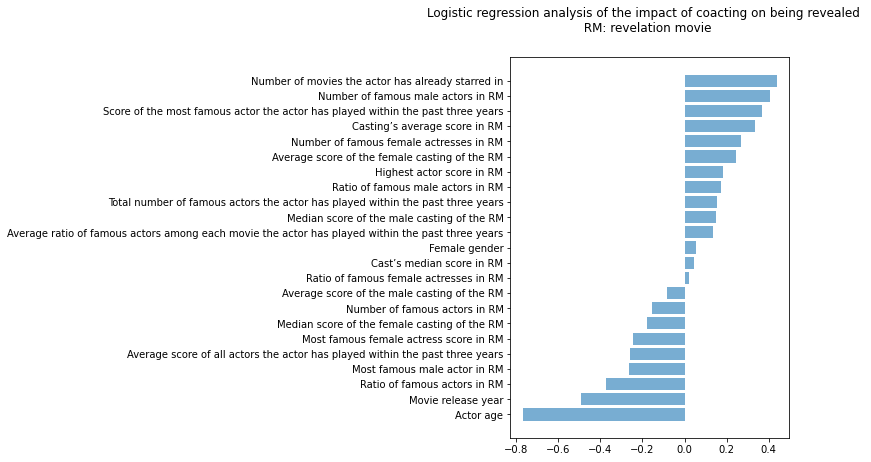

<Figure size 432x288 with 0 Axes>

In [69]:
OUTPUT_IMG_LOGISTIC_REGRESSION_REVELATION = os.path.join(OUTPUT_LOGISTIC_IMAGES_PATH, 'logistic_regression_revelation.svg')
compute_logistic_regression_weights(regression_revelation_results, feature_columns=columns, output_filename=OUTPUT_IMG_LOGISTIC_REGRESSION_REVELATION)

In [70]:
OUTPUT_CSV_WEIGHTS_LOGISTIC_REGRESSION_REVELATION = 'weights_regression_revelation.csv'
regression_columns_weight, regression_columns_mean = retrieve_regression_weights(regression_revelation_results, scaler=scaler, feature_columns=columns, output_filename=OUTPUT_CSV_WEIGHTS_LOGISTIC_REGRESSION_REVELATION)

# 4. Stay in the loop
## 4.1 Load the yearly numbers dataset

In [71]:
SCORE_YEARLY_PATH = os.path.join(DATA_PATH, 'score_yearly.tsv')
df_numbers_yearly = pd.read_csv(SCORE_YEARLY_PATH, sep="\t")
df_numbers_yearly.set_index('actor_name', inplace=True)
df_numbers_yearly.head(2)

,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,175.0,166.0,99.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,...,0.0,16.0,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0
Clint Eastwood,97.0,89.0,174.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,...,0.0,0.0,0.0,0.0,0.0,71.0,0.0,0.0,36.0,0.0


## 4.2 Retrieve the score of the actor, the next year after his·her revelation

In [72]:
df_loop = df_regression_merged.copy()
df_loop = df_loop.loc[
    (df_loop['already_revealed'] == 1) & (df_loop['nb_movies_before_this_movie'] >= 1)].sort_values(
    ['actor_name', 'm_release_year']).drop_duplicates(['actor_name'], keep='first').copy()
df_loop.head()

,actor_name,m_release_year,wikipedia_m_ID,actor_age,min_year,min_year_score,min_year_starring,is_revealed,already_revealed,actor_gender_cat,...,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,previous_cast_max,previous_cast_mean,previous_cast_prop_famous_actors,previous_cast_nb_famous_actors
58,Aaliyah,2002,9088886.00,22.00,2000.0,54.0,2000.0,0.0,1.0,1.0,...,0.000000,0.0,0.000000,0.0,0.00,0.000000,27.000000,1.377778,0.100000,1.00
88,Aaron Eckhart,2004,939561.00,36.00,2003.0,11.0,1994.0,0.0,1.0,0.0,...,33.000000,0.0,4.714286,0.0,1.00,0.100000,2261.794444,120.088226,0.375000,6.00
162,Aaron Yoo,2009,17930105.75,29.25,2008.0,65.0,2007.0,0.0,1.0,0.0,...,492.869444,0.0,58.863315,0.0,2.25,0.139067,516.220960,22.653759,0.267023,4.25
190,Abbie Cornish,2012,33757147.00,30.00,2011.0,13.0,2006.0,0.0,1.0,1.0,...,1683.388889,0.0,383.070481,0.0,4.00,0.266667,4858.138930,234.019930,0.400000,6.00
229,Abigail Breslin,2007,10746393.00,11.00,2006.0,50.0,2002.0,0.0,1.0,1.0,...,8.250000,0.0,2.750000,0.0,1.00,0.111111,858.636111,43.204688,0.333333,3.75


In [73]:
def is_still_ranked(row):
    """
    Outputs a new binary column which is true when the actor is still ranked in the numbers in the next movie after
    his·her revelation

    :param row: row of the df characters
    :return:1 if the actor is still ranked in the numbers in the next movie after his·her revelation otherwise 0
    """

    score_year_to_retrieve = row['m_release_year']
    actor_name = row['actor_name']
    try:
        score = df_numbers_yearly['{}'.format(score_year_to_retrieve)][actor_name]
        return 1 if score else 0
    except:
        raise ValueError('The actor {} is already_revealed but is not in df numbers'.format(row.actor_name))

In [74]:
df_loop['still_ranked'] = df_loop.apply(lambda row: is_still_ranked(row), axis=1)

In [75]:
df_loop['is_main_actor'] = (df_loop['cast_max'] == df_loop['min_year_score']).astype(int)

In [76]:
columns = df_numbers_yearly.columns[1:]

In [77]:
main_actors = df_loop[df_loop['is_main_actor'] == 1]
not_main_actors = df_loop[df_loop['is_main_actor'] == 0]

In [78]:
# There is no significant difference among actors who were still ranked, whether they were the main actor of their movie or not.
ttest_ind(main_actors['still_ranked'], not_main_actors['still_ranked'])

Ttest_indResult(statistic=-1.0921828025045788, pvalue=0.27493920549658835)

# 4.3 Are there patterns between actors to stay in the loop?

In [79]:
features_loop = ['cast_max', 'cast_mean', 'cast_median', 'cast_nb_famous_actors','cast_prop_famous_actors', 
                       'F_max', 'F_mean', 'F_median', 'F_nb_famous_actors', 'F_prop_famous_actors', 
                       'M_max', 'M_mean', 'M_median', 'M_nb_famous_actors', 'M_prop_famous_actors', 
                       'previous_cast_max', 'previous_cast_mean', 'previous_cast_prop_famous_actors',
                       'previous_cast_nb_famous_actors', 
                       'm_release_year', 'actor_age', 'actor_gender_cat', 'nb_movies_before_this_movie',
                       'still_ranked']

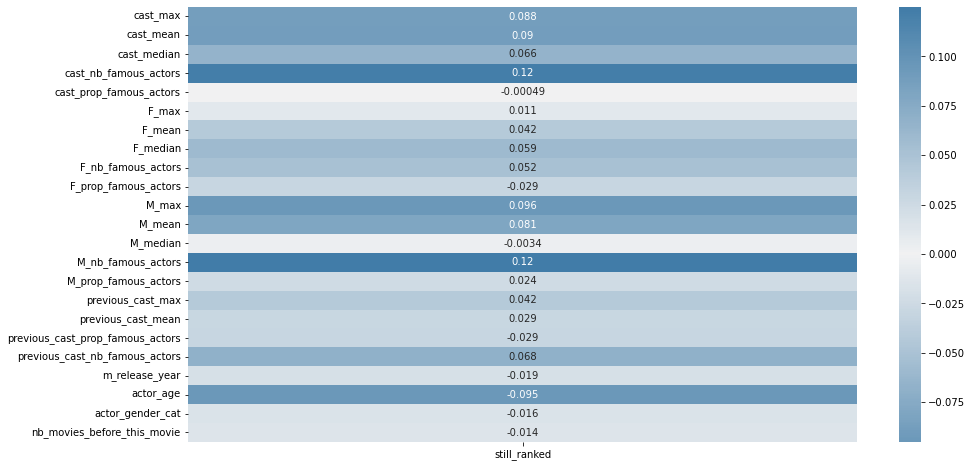

In [80]:
columns = features_loop
dataset = df_loop[features_loop].fillna(0)

# Heatmap of the correlation between the attributes and the output 'is_revealed'
corr = dataset.corr()
corr.drop(corr.tail(1).index, inplace=True)

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240, 240, as_cmap=True)
sns.heatmap(data=corr[['still_ranked']], cmap=cmap, center=0, annot=True)
plt.show()

In [81]:
features_loop = ['wikipedia_m_ID', 'character_name', 'actor_dob', 'actor_gender',
                 'actor_name', 'actor_age', 'm_name', 'm_genre_PCA', 'm_release_year',
                'min_year', 'min_year_score', 'min_year_starring', 'is_revealed',
       'already_revealed', 'popularity', 'actor_gender_cat', 'nb_actors',
       'nb_movies_before_this_movie', 'nb_movies_dec_1980_1990',
       'nb_movies_dec_1990_2000', 'nb_movies_dec_2000_2010',
       'nb_movies_dec_2010_2020', 'actor_score', 'cast_max', 'cast_min',
       'cast_mean', 'cast_median', 'cast_nb_famous_actors',
       'cast_prop_famous_actors', 'F_max', 'F_min', 'F_mean', 'F_median',
       'F_nb_famous_actors', 'F_prop_famous_actors', 'M_max', 'M_min',
       'M_mean', 'M_median', 'M_nb_famous_actors', 'M_prop_famous_actors',
       'still_ranked'
]

In [82]:
nb_still_ranked = dataset['still_ranked'].value_counts()[1]
nb_all = dataset['still_ranked'].count()
print("Among actors 1st movie after their revelation, there are {} actors that performed a new score which corresponds to {:.2f}% of those actors.".format(nb_still_ranked, nb_still_ranked/nb_all*100))

Among actors 1st movie after their revelation, there are 320 actors that performed a new score which corresponds to 22.65% of those actors.


Classification report for Stay in the loop actors:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      1006
           1       0.68      0.71      0.70       994

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



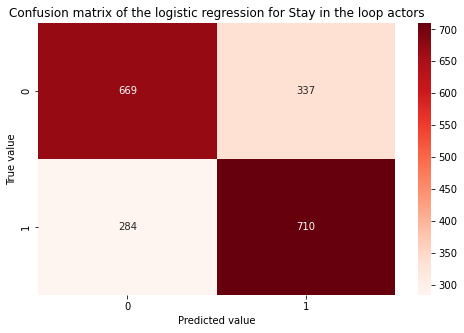

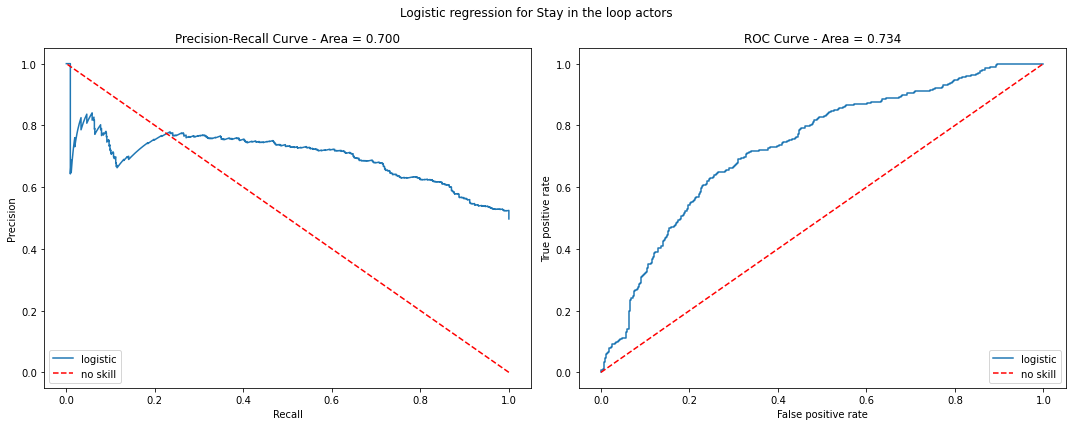

In [83]:
nb_trials = 100
nb_features = dataset.shape[1]-1
nb_samples_per_training = 2000
PATH_REGRESSION_STAY_LOOP_CMATRIX = os.path.join(OUTPUT_LOGISTIC_IMAGES_PATH, 'regression_stay_loop_cm.svg')
regression_stay_loop_results, _ = compute_regressor(df_loop, feature_columns=columns, target_column='still_ranked', nb_trials=nb_trials, nb_features=nb_features, nb_samples_per_training=nb_samples_per_training)
plot_logistic_regression_results(regression_stay_loop_results, PATH_REGRESSION_STAY_LOOP_CMATRIX, title='Stay in the loop actors')

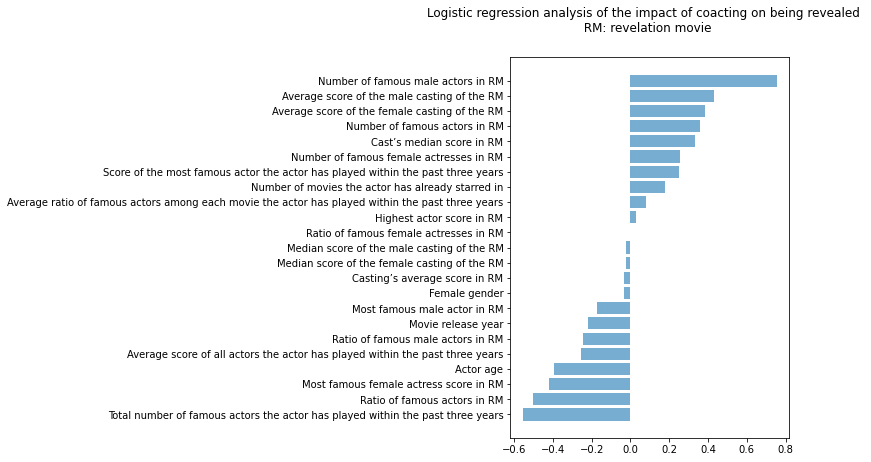

<Figure size 432x288 with 0 Axes>

In [84]:
OUTPUT_IMG_LOGISTIC_REGRESSION_LOOP = os.path.join(OUTPUT_LOGISTIC_IMAGES_PATH, 'logistic_regression_stay_in_the_loop.svg')
compute_logistic_regression_weights(regression_stay_loop_results, feature_columns=columns, output_filename=OUTPUT_IMG_LOGISTIC_REGRESSION_LOOP)

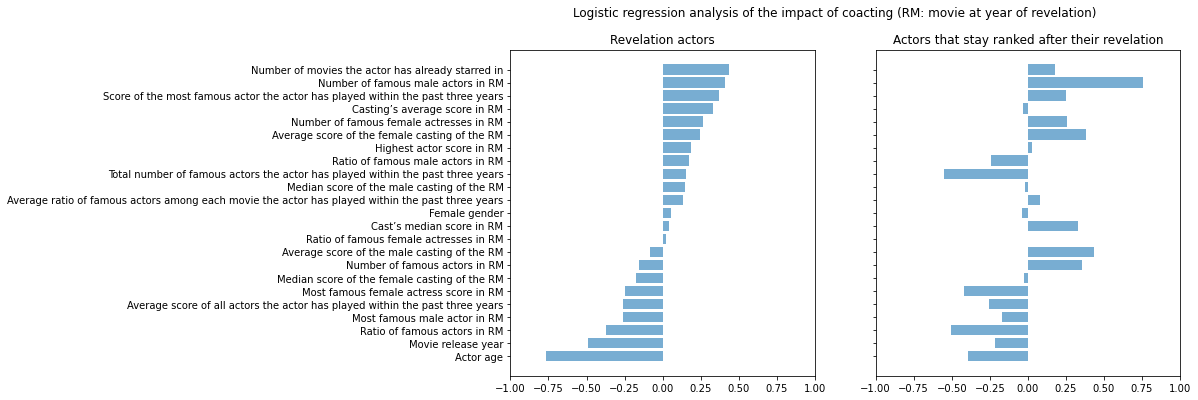

<Figure size 432x288 with 0 Axes>

In [85]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(columns[:-1], regression_revelation_results['clf'].coef_[0]):
    tmp.append({"name": logistic_regression_col_names[name], "value": value})

tmp_2 = []
for name, value in zip(columns[:-1], regression_stay_loop_results['clf'].coef_[0]):
    tmp_2.append({"name": logistic_regression_col_names[name], "value": value})
    

features_coef_1 = pd.DataFrame(tmp).sort_values("value")
features_coef_2 = pd.DataFrame(tmp_2).sort_values("value")

#Plot the feature comparison between the logistic regression for the revelation actors and the one for the second movie
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].barh(features_coef_1.name, features_coef_1.value, alpha=0.6)
axs[1].barh(features_coef_2.name, features_coef_2.value, alpha=0.6)
axs[0].set_xlim(-1, 1)
axs[1].set_xlim(-1, 1)
axs[0].set_title("Revelation actors")
axs[1].set_title("Actors that stay ranked after their revelation")
fig.suptitle('Logistic regression analysis of the impact of coacting (RM: movie at year of revelation)')

plt.show()
plt.tight_layout()

image_format = 'svg'
OUTPUT_IMG_LOGISTIC_REGRESSION_COMPARISON = os.path.join(OUTPUT_LOGISTIC_IMAGES_PATH, 'logistic_regression_comparison.svg')
image_name = OUTPUT_IMG_LOGISTIC_REGRESSION_COMPARISON

fig.savefig(image_name, format=image_format, dpi=1200)